# Maxwell solver with leap-frog scheme

We implement a leap-frog scheme for the Maxwell equations in vacuum

$$
\begin{align}
    - \frac{\partial \mathbf{E}}{\partial t} + \nabla \times \mathbf{B} & = 0 \\[3mm]
    \frac{\partial \mathbf{B}}{\partial t} + \nabla \times \mathbf{E} & = 0
\end{align}
$$

See the [fourth exercise sheet](http://www-m16.ma.tum.de/foswiki/pub/M16/Allgemeines/CompPlasmaPhys22/exercise04.pdf) for details.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# a function to update the electric field vector E using np.roll and matrix operations
def adv_update_E_vec(dt, h, E_vec, B_vec):
    """
    Updates the electric field with time-step size dt

    Parameters:
        dt    : time-step size
        h     : array of grid-spacings in all 3 directions
        E_vec : array of electric field vector
        B_vec : array of magnetic field vector
    """
    E_vec_new = np.zeros( np.shape(E_vec), dtype=float)
    
    delta_n = dt / h; # a vector
    
    E_vec_new[0,:,:,:] = E_vec[0,:,:,:] + (delta_n[1] * (B_vec[2,:,:,:] - np.roll(B_vec[2,:,:,:], 1, axis=1)) - delta_n[2] * ((B_vec[1,:,:,:] - np.roll(B_vec[1,:,:,:], 1, axis=2))))
    E_vec_new[1,:,:,:] = E_vec[1,:,:,:] + (delta_n[2] * (B_vec[0,:,:,:] - np.roll(B_vec[0,:,:,:], 1, axis=2)) - delta_n[0] * ((B_vec[2,:,:,:] - np.roll(B_vec[2,:,:,:], 1, axis=0))))
    E_vec_new[2,:,:,:] = E_vec[2,:,:,:] + (delta_n[0] * (B_vec[1,:,:,:] - np.roll(B_vec[1,:,:,:], 1, axis=0)) - delta_n[1] * ((B_vec[0,:,:,:] - np.roll(B_vec[0,:,:,:], 1, axis=1))))  
       
    return E_vec_new


# a function to update the magnetic field vector E using np.roll and matrix operations
def adv_update_B_vec(dt, h, E_vec, B_vec):
    """
    Updates the magnetic field with time-step size dt

    Parameters:
        dt    : time-step size
        h     : array of grid-spacings in all 3 directions
        E_vec : array of electric field vector
        B_vec : array of magnetic field vector
    """
    B_vec_new = np.zeros( np.shape(B_vec), dtype=float)

    delta_n = dt / h; # a vector
    
    B_vec_new[0,:,:,:] = B_vec[0,:,:,:] - (delta_n[1] * (-E_vec[2,:,:,:] + np.roll(E_vec[2,:,:,:], -1, axis=1)) - delta_n[2] * ((-E_vec[1,:,:,:] + np.roll(E_vec[1,:,:,:], -1, axis=2))))
    B_vec_new[1,:,:,:] = B_vec[1,:,:,:] - (delta_n[2] * (-E_vec[0,:,:,:] + np.roll(E_vec[0,:,:,:], -1, axis=2)) - delta_n[0] * ((-E_vec[2,:,:,:] + np.roll(E_vec[2,:,:,:], -1, axis=0))))
    B_vec_new[2,:,:,:] = B_vec[2,:,:,:] - (delta_n[0] * (-E_vec[1,:,:,:] + np.roll(E_vec[1,:,:,:], -1, axis=0)) - delta_n[1] * ((-E_vec[0,:,:,:] + np.roll(E_vec[0,:,:,:], -1, axis=1))))
         
    return B_vec_new

def eval_E_ana(t, Omega, N):
    E_ana_temp = np.empty([3, N[0], N[1], N[2]])

    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                E_ana_temp[0,i,j,k] = Ex_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
                E_ana_temp[1,i,j,k] = Ey_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
                E_ana_temp[2,i,j,k] = Ez_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
    
    return E_ana_temp

def eval_B_ana(t, Omega, N):
    B_ana_temp = np.empty([3, N[0], N[1], N[2]])

    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                B_ana_temp[0,i,j,k] = Bx_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
                B_ana_temp[1,i,j,k] = By_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
                B_ana_temp[2,i,j,k] = Bz_ana(t, Omega[0][i], Omega[1][j], Omega[2][k])
    
    return B_ana_temp

Now come 32 elements.


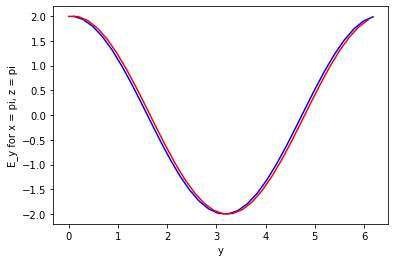

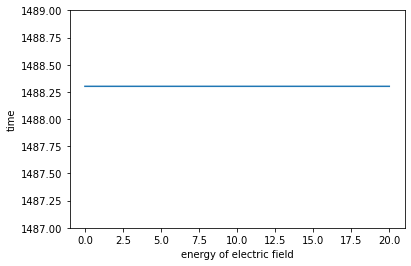

In [15]:
# Set parameters for time iteration
t_end       = 20
dt          = 0.005


N_timesteps = int(t_end/dt)

# Set parameter for space
N = [2**5]*3
a = 0
b = 2*np.pi


# Implement analytical test solution
Ex_ana = lambda t,x,y,z : np.cos( x + y + z - np.sqrt(3)*t )
Ey_ana = lambda t,x,y,z : -2*np.cos( x + y + z - np.sqrt(3)*t )
Ez_ana = lambda t,x,y,z : np.cos( x + y + z - np.sqrt(3)*t )

Bx_ana = lambda t,x,y,z : np.sqrt(3)*np.cos( x + y + z - np.sqrt(3)*t )
By_ana = lambda t,x,y,z : 0.
Bz_ana = lambda t,x,y,z : -np.sqrt(3)*np.cos( x + y + z - np.sqrt(3)*t )


Omega = [None]*3
h     = np.empty(3, dtype=float)
for i in range(3):
    Omega[i] = np.linspace(a, b, N[i]+1)[:-1]
    h[i]     = Omega[i][1] - Omega[i][0]

print('Now come '+str(N[0])+' elements.')

# Create initial conditions arrays from analytical solutions
E0   = np.zeros( (3,N[0],N[1],N[2]), dtype=float )
B0   = np.zeros( (3,N[0],N[1],N[2]), dtype=float )

# Create initial conditions arrays

for i in range(N[0]):
    for j in range(N[1]):
        for k in range(N[2]):
            E0[0,i,j,k] = Ex_ana(0, Omega[0][i] + h[0] / 2, Omega[1][j], Omega[2][k])
            E0[1,i,j,k] = Ey_ana(0, Omega[0][i], Omega[1][j] + h[1] / 2, Omega[2][k])
            E0[2,i,j,k] = Ez_ana(0, Omega[0][i], Omega[1][j], Omega[2][k] + h[2] / 2)
            B0[0,i,j,k] = Bx_ana(dt/2, Omega[0][i], Omega[1][j] + h[1] / 2, Omega[2][k] + h[2] / 2)
            B0[1,i,j,k] = By_ana(dt/2, Omega[0][i] + h[0] / 2, Omega[1][j], Omega[2][k] + h[2] / 2)
            B0[2,i,j,k] = Bz_ana(dt/2, Omega[0][i] + h[0] / 2, Omega[1][j] + h[1] / 2, Omega[2][k])


            
            
# Set starting value to initial condition
E_vec = E0.copy()
B_vec = B0.copy()

energy = np.empty(N_timesteps, dtype=float)

for k in range(N_timesteps):
    E_vec = adv_update_E_vec(dt, h, E_vec, B_vec)
    B_vec = adv_update_B_vec(dt, h, E_vec, B_vec)

    energy[k] = (np.sum(np.multiply(E_vec, E_vec)) + np.sum(np.multiply(B_vec, B_vec))) / N[0]**3 * (2 * np.pi)**(3)

    # Plot a component of the electric or magnetic field and the analytical solution

# Create analytical solution
E_ana = eval_E_ana(t_end, Omega, N) 
B_ana = eval_B_ana(t_end + dt/2, Omega, N)


plt.plot(Omega[1] + h[1] / 2, E_vec[1,16,:,16], label='approximation', color = 'blue')
plt.plot(Omega[1], E_ana[1,16,:,16], label='analytical', color = 'red')
plt.xlabel("y")
plt.ylabel("E_y for x = pi, z = pi")
plt.show()


plt.figure()
plt.plot(np.linspace(0, t_end, N_timesteps), energy)
plt.xlabel("energy of electric field")
plt.ylabel("time")
plt.ylim([1487, 1489])
plt.show()


We can see, that the leap-frog scheme in time, combined with the Yee scheme in space, quite well approximates the analytical solution. It also conserves energy with high precision. 